In [1]:
import os
os.chdir('./../..')
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets.ascad_datasets import AscadDataset
from models.lstm import LstmModel

In [2]:
train_dataset = AscadDataset(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = AscadDataset(train=False)
test_dataloader = DataLoader(test_dataset, batch_size=64)
loss_fn = nn.MSELoss()

In [3]:
train_loss_vals = {}
test_loss_vals = {}
train_max_dist = {}
test_max_dist = {}

n_epochs = 100
delay = 1

widths = [64, 128, 256, 512, 1024]
depths = [3]

for width in widths:
    for depth in depths:
        print('Width:', width, 'Depth:', depth)
        model = LstmModel(width, depth, delay=delay).cuda()
        optimizer = optim.Adam(model.parameters(), lr=2e-4)
        train_loss_vals.update({(width, depth): []})
        test_loss_vals.update({(width, depth): []})
        train_max_dist.update({(width, depth): []})
        test_max_dist.update({(width, depth): []})
        
        for epoch in tqdm(range(n_epochs)):
            for batch in train_dataloader:
                trace, _ = batch
                trace = trace.cuda()
                logits = model(trace)
                loss = loss_fn(logits, trace)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
                optimizer.step()
                train_loss_vals[(width, depth)].append(loss.detach().cpu().numpy())
                max_dist = np.mean(np.max(np.abs(trace.detach().cpu().numpy()-logits.detach().cpu().numpy()), axis=1))
                train_max_dist[(width, depth)].append(max_dist)
            with torch.no_grad():
                for batch in test_dataloader:
                    trace, _ = batch
                    trace = trace.cuda()
                    logits = model(trace)
                    loss = loss_fn(logits, trace)
                    test_loss_vals[(width, depth)].append(loss.cpu().numpy())
                    max_dist = np.mean(np.max(np.abs(trace.cpu().numpy()-logits.cpu().numpy()), axis=1))
                    test_max_dist[(width, depth)].append(max_dist)
            train_loss_vals[(width, depth)][epoch] = np.mean(train_loss_vals[(width, depth)][epoch:])
            train_max_dist[(width, depth)][epoch] = np.mean(train_max_dist[(width, depth)][epoch:])
            test_loss_vals[(width, depth)][epoch] = np.mean(test_loss_vals[(width, depth)][epoch:])
            test_max_dist[(width, depth)][epoch] = np.mean(test_max_dist[(width, depth)][epoch:])
            del train_loss_vals[(width, depth)][epoch+1:]
            del train_max_dist[(width, depth)][epoch+1:]
            del test_loss_vals[(width, depth)][epoch+1:]
            del test_max_dist[(width, depth)][epoch+1:]

Width: 64 Depth: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:02:42<00:00, 37.63s/it]


Width: 128 Depth: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:04:12<00:00, 74.52s/it]


Width: 256 Depth: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:05:55<00:00, 147.56s/it]


Width: 512 Depth: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:44:34<00:00, 458.75s/it]


Width: 1024 Depth: 3


  1%|█▋                                                                                                                                                                  | 1/100 [36:56<60:57:20, 2216.57s/it]


KeyboardInterrupt: 

In [4]:
import pickle
import os

with open(os.path.join('.', 'results', 'lstm_autoencoder_width_depth_sweep', 'data.pickle'), 'wb') as F:
    pickle.dump({
        'train_l2_dists': train_loss_vals,
        'test_l2_dists': test_loss_vals,
        'train_sup_dists': train_max_dist,
        'test_sup_dists': test_max_dist
    }, F)

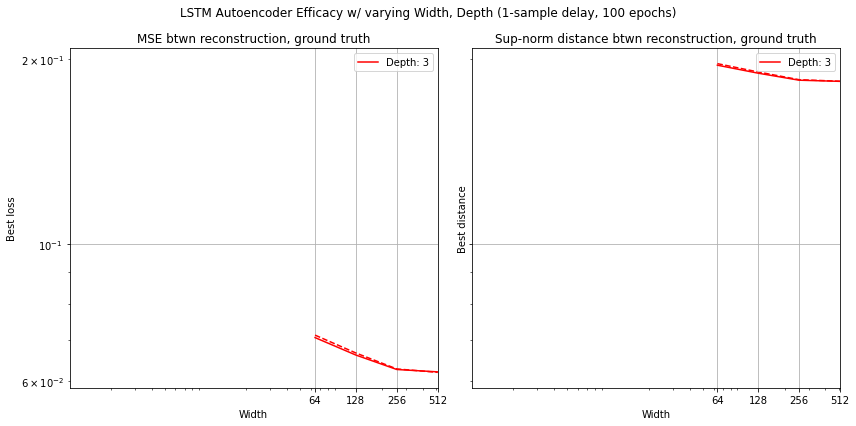

In [6]:
depths = [3]
widths = [64, 128, 256, 512]
train_losses = {d: [] for d in depths}
test_losses = {d: [] for d in depths}
train_dists = {d: [] for d in depths}
test_dists = {d: [] for d in depths}
for d in depths:
    for w in widths:
        train_losses[d].append(np.min(train_loss_vals[(w, d)]))
        test_losses[d].append(np.min(test_loss_vals[(w, d)]))
        train_dists[d].append(np.min(train_max_dist[(w, d)]))
        test_dists[d].append(np.min(test_max_dist[(w, d)]))

(fig, axes) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
for depth, color in zip(depths, ['red', 'blue', 'green']):
    axes[0].plot(widths, train_losses[depth], linestyle='--', color=color)
    axes[0].plot(widths, test_losses[depth], linestyle='-', color=color, label='Depth: %d'%(depth))
    axes[1].plot(widths, train_dists[depth], linestyle='--', color=color)
    axes[1].plot(widths, test_dists[depth], linestyle='-', color=color, label='Depth: %d'%(depth))
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlabel('Width')
axes[1].set_xlabel('Width')
axes[0].set_ylabel('Best loss')
axes[1].set_ylabel('Best distance')
axes[0].set_title('MSE btwn reconstruction, ground truth')
axes[1].set_title('Sup-norm distance btwn reconstruction, ground truth')
axes[0].legend()
axes[1].legend()
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_xlim(1, 128)
axes[1].set_xlim(1, 128)
axes[0].set_xticks(widths)
axes[1].set_xticks(widths)
axes[0].set_xticklabels(widths)
axes[1].set_xticklabels(widths)
fig.suptitle('LSTM Autoencoder Efficacy w/ varying Width, Depth (%d-sample delay, %d epochs)'%(delay, n_epochs))
plt.tight_layout()
fig.savefig(os.path.join('.', 'results', 'lstm_autoencoder_width_depth_sweep', 'sweep.pdf'))

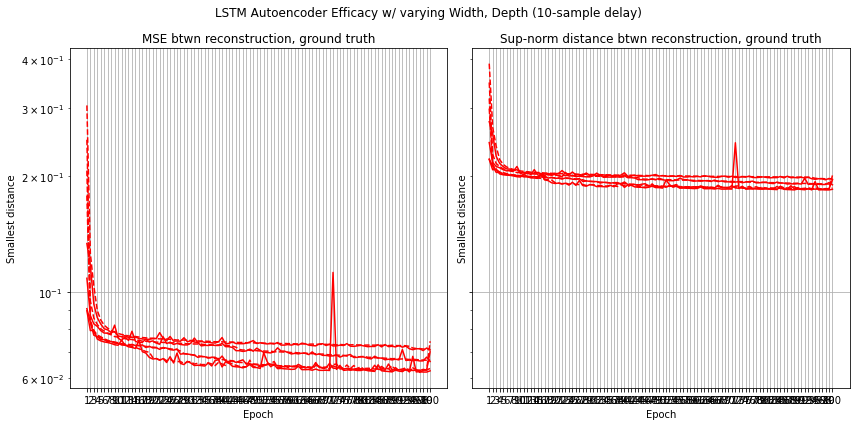

In [8]:
(fig, axes) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
epochs = np.arange(1, 101)
for width in widths:
    for depth, color in zip(depths, ['red', 'blue', 'green']):
        axes[0].plot(epochs, train_loss_vals[(width, depth)], color=color, linestyle='--')
        axes[0].plot(epochs, test_loss_vals[(width, depth)], color=color, linestyle='-')
        axes[1].plot(epochs, train_max_dist[(width, depth)], color=color, linestyle='--')
        axes[1].plot(epochs, test_max_dist[(width, depth)], color=color, linestyle='-')
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')
axes[0].set_ylabel('Smallest distance')
axes[1].set_ylabel('Smallest distance')
axes[0].set_title('MSE btwn reconstruction, ground truth')
axes[1].set_title('Sup-norm distance btwn reconstruction, ground truth')
axes[0].grid(True)
axes[1].grid(True)
axes[0].set_xticks(epochs)
axes[1].set_xticks(epochs)
axes[0].set_xticklabels(epochs)
axes[1].set_xticklabels(epochs)
fig.suptitle('LSTM Autoencoder Efficacy w/ varying Width, Depth (10-sample delay)')
plt.tight_layout()
fig.savefig(os.path.join('.', 'results', 'lstm_autoencoder_delay_sweep', 'training_curves.pdf'))